In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from core import DataLoader
from enums import PostType, VoteType

In [25]:
Ethereum = DataLoader('../data/ethereum')

In [11]:
Crypto = DataLoader('../data/crypto')

In [2]:
Christianity = DataLoader('../data/christianity')

In [23]:
Judaism = DataLoader('../data/judaism')

In [5]:
def get_tags(posts):
    tags = set()
    for tags_string in posts['Tags'].unique():
        if not tags_string:
            continue

        tags_ = tags_string.split('><')
        tags_ = [x.strip('<').strip('>') for x in tags_]

        tags.update(tags_)
    
    return tags

## Trudność uzyskania odznaki

Chcemy posortować odznaki względem trudności ich uzyskania. Miarą "trudności" będziemy liczyli średnią liczbę uzyskanych pozytywnych ocen przed uzyskaniem odznaki przez userów, kto już ją otrzymał.

Tablica ***Badges*** zawiera też odznaki, które mają takie same nazwy, co i tagi - takie odznaki zostały usunięte.

Funkcja zwracająca tablicę zawierającą nazwę odznaki i jej ***trudność*** do uzyskania:

In [9]:
def difficulty_getting_badge(db):
    badges = Crypto.badges_df.copy()[['Name', 'UserId', 'Date']]
    posts = Crypto.posts_df.copy()[['Id', 'OwnerUserId', 'CreationDate', 'Tags']]
    votes = Crypto.votes_df.copy()[['PostId', 'VoteTypeId', 'CreationDate']]
    
    tags = get_tags(posts)
    
    badges = badges[~badges['Name'].isin(tags)]
    
    badges['Date'] = pd.to_datetime(badges['Date'])
    posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])
    
    first_badges = badges.loc[badges.groupby(['Name', 'UserId'])['Date'].idxmin()]
    
    badges_posts = first_badges.merge(posts, left_on='UserId', right_on='OwnerUserId')
    badges_posts = badges_posts[badges_posts['CreationDate'] < badges_posts['Date']][['Name', 'UserId', 'Date', 'Id']]
    
    badges_votes = badges_posts.merge(votes, left_on='Id', right_on='PostId')
    badges_votes = badges_votes[badges_votes['CreationDate'] < badges_votes['Date']]
    badges_up_votes = badges_votes[badges_votes['VoteTypeId'] == VoteType.UP][['Name', 'UserId']]
    
    s = badges_up_votes.groupby(['Name', 'UserId']).size()
    names = [x[0] for x in s.index]
    user_ids = [x[1] for x in s.index]
    d = pd.DataFrame({'BadgeName': names, 'UserId':user_ids, 'UPVotes':s.values})
    d = d.sort_values(['UPVotes']).groupby('BadgeName')['UPVotes'].mean()
    d = pd.DataFrame({'BadgeName': d.index, 'UPVotes': d.values}).sort_values('UPVotes', ascending=False)
    
    return d.reset_index()[['BadgeName', 'UPVotes']]

Znajdziemy "trudności" uzyskania każdej z odznak w zbiorze danych ***Crypto***:

In [12]:
df = difficulty_getting_badge(Crypto)

10 odznak najtrudniejszych do uzyskania:

In [13]:
df[:10]

,BadgeName,UPVotes
0,Socratic,6422.000000
1,Sheriff,3586.571429
2,Great Answer,2333.055556
3,Lifejacket,2321.823529
4,Populist,2025.333333
5,Synonymizer,2006.636364
6,Outspoken,1930.307692
7,Archaeologist,1908.400000
8,Refiner,1788.888889
9,Copy Editor,1685.875000


10 odznak najłatwiejszych do uzyskania:

In [14]:
df[-10:]

,BadgeName,UPVotes
73,Tumbleweed,17.582569
74,Popular Question,14.189790
75,Autobiographer,12.542838
76,Commentator,12.088818
77,Precognitive,7.200000
78,Scholar,3.972141
79,Supporter,3.965991
80,Editor,3.922631
81,Teacher,3.722061
82,Student,2.247622


Histogram średniej liczby pozytywnych ocen potrzebnych do otrzymania odznaki:

(array([60., 10.,  6.,  5.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([2.24762250e+00, 6.44222860e+02, 1.28619810e+03, 1.92817334e+03,
        2.57014857e+03, 3.21212381e+03, 3.85409905e+03, 4.49607429e+03,
        5.13804952e+03, 5.78002476e+03, 6.42200000e+03]),
 <BarContainer object of 10 artists>)

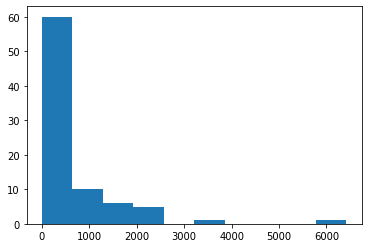

In [16]:
plt.hist(df['UPVotes'])

## Powiązane tagi

Próbujemy wśród wszystkich tagów występujących w zbiorze danych znaleźć takie, które są podtematem innych, np. tag ***python*** jest podtematem tagu ***programming***.

Żeby znaleźć takie tagi, dla każdych 2 tagów wyliczamy:
- liczbę postów z 1 tagiem
- liczbę postów z 2 tagiem
- liczbę postów z obydwoma tagami

Po czym na podstawie zebranych danych obliczamy jaki procent postów z tagiem pierwszym zawiera też tag drugi i na odwrót. Jeżeli ten procent jest odpowiednio duży, to zakładamy, że jeden z nich (z większym procentem) jest podtematem innego.

Reprezendacja drzewa powiązanych tagów wygląda następująco (tagi 2 i 3 są podtematami 1; 5 jest podtematem 4; 1 i 7 są niezależne):

Jeśli tag nie jest podtematem innego i nie zawiera podtematów, w reprezentacji drzewa go omijamy.

Funkcja znajdująca i wypisująca drzewo powiązanych tagów dla tabeli ***posts*** z dowolnego zbioru danych:

In [6]:
def find_sub_tags(posts_df, precision=.5):
    posts = posts_df
    
    tags = get_tags(posts)
    
    tag_n = {}
    for tag in tags:
        tag_n[tag] = len(posts[posts['Tags'].str.contains(f'<{tag}>', regex=False, na=False)])
    
    co_tags = {}
    for index, row in posts.iterrows():
        if not row['Tags']:
            continue

        tags_ = row['Tags'].split('><')
        tags_ = [x.strip('<').strip('>') for x in tags_]

        for tag1 in tags_:
            for tag2 in tags_:
                if tag1 >= tag2:
                    continue
                co_tags[(tag1, tag2)] = co_tags.get((tag1, tag2), 0) + 1
    
    likely_parent = {}
    for tag in tags:
        parent = None
        union_percent = 0

        for p in tags:
            if (nu := co_tags.get((min(tag, p), max(tag, p)))):
                if precision * 100 < (u_percent := nu / tag_n[tag] * 100) and u_percent > union_percent:
                    union_percent = u_percent
                    parent = p

        if parent:
            likely_parent[tag] = parent

    likely_children = {}
    for tag in likely_parent.values():
        likely_children[tag] = []
        for child, p in likely_parent.items():
            if tag == p:
                likely_children[tag].append(child)
    
    class Node:
        def __init__(self, name):
            self.name = name
            self.children = []
            self.parent = None

        def show(self, offset=0):
            print(self.name, end='')

            if self.children:
                print()
                for child in self.children:
                    print(' ' * (offset + len(self.name) - 1) + '|- ', end='')
                    child.show(offset + len(self.name) + 2)

            print()
    
    nodes = [Node(t) for t in tags]
    
    for parent, children in likely_children.items():
        parent = [node for node in nodes if node.name == parent][0]
        for child in children:
            child = [node for node in nodes if node.name == child][0]
            child.parent = parent
            parent.children.append(child)
        parent.children.sort(key=lambda x: x.name)
    
    nodes.sort(key=lambda x: x.name)
    for parent in nodes:
        if parent.parent is None and parent.children:
            parent.show()

Znajdziemy powiązane tagi ze zbioru danych ***Christianity***:

In [7]:
find_sub_tags(Christianity.posts_df.copy())

abraham
      |- isaac
      |- sarah

acts
   |- ananias-and-sapphira
   |- council-of-jerusalem

adam-and-eve
           |- garden-of-eden

aliens
     |- humans

angels
     |- 4-living-creatures
     |- archangels
     |- guardian-angels

anglicanism
          |- articles-of-religion

apologetics
          |- bart-ehrman
          |- ces-letter
          |- isaac-of-troki
          |- presuppositionalism

apostles
       |- matthias

apostolic-fathers
                |- fornication
                             |- litany

                |- pre-nicene-fathers

archaeology
          |- paleography

arianism
       |- theodosius

arius
    |- st.-nicholas
                  |- santa-claus


atonement
        |- penal-substitution
        |- ransom-theory
        |- recapitulation-theory

baptism
      |- infants
      |- jesus-name-baptism
      |- paedobaptism

bible
    |- biblical-fiction
    |- book-of-life
    |- versification

bible-commentary
               |- matthew-henry

bib

Możemy w wyniku zobaczyć ścieżki wygenerowane przez ten algorytm, np. ***catholicism - virgin-mary - assumption-of-mary***.

Bardzo ważny jest ***minimalny procent czułości***, tzn. minimalny procent który jest potrzebny, by stwierdzić, że jeden tag jest podtematem innego. Im on jest większy, tym mniej zależności zostanie znaleziono ale prawdopodobieństwo, że są rzeczywiście związane będzie większe. Z drugiej strony im on jest mniejszy, tym więcej mniej jawnych zależności możemy odnaleźć.

Wartością domyślną tego procentu jest 0.5 (***50%***), jak zmniejszymy go do 0.1 (***10%***) zaobserwujemy następujące drzewo:

In [8]:
find_sub_tags(Christianity.posts_df.copy(), .1)

bible
    |- applications
    |- bible-reading
    |- bible-translation
                       |- copyright
                       |- esv
                            |- nasb

                       |- kjv
                            |- kjv-onlyism
                            |- niv
                            |- nkjv

                       |- nrsv
                       |- septuagint
                                   |- masoretic-text

                       |- textual-criticism

    |- biblical-fiction
    |- biblical-reliability
    |- book-of-life
    |- canon
           |- book-of-enoch
           |- deuterocanonical-books
           |- gospel-of-thomas
           |- protestant-bible
           |- pseudepigrapha

    |- inerrancy
    |- inspiration
    |- scriptures
                |- churches
                          |- sanctity

                |- printing-press

    |- versification

biblical-basis
             |- church-of-the-nazarene
             |- church-offices
        

Możemy na przykład zobaczyć, że tag ***church-history*** nie tylko pojawił się w tym drzewie, ale i jest bardzo rozbudowany.